In [1]:
import os
import os.path as path
import re
from enum import Enum

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
import matplotlib.patheffects as PathEffects
import pandas as pd
import seaborn as sns

from tqdm.notebook import tqdm
# tqdm.pandas(desc='Processing Dataframe', leave=False, position=1)
# import tafra
# import ptitprince as pt

mpl.style.use('seaborn')
# %matplotlib notebook
# xkcd-colors: https://matplotlib.org/stable/_images/sphx_glr_colors_003.png

In [2]:
block_eval_file = './block_eval_survey.csv'
column_mapping = {
    'Block Information [Block ID]' : "Block",
    'Block Information [Subject ID]' : 'SubjectId',
    'Order in which conditions occured [Rank 1]' : "1stCondition",
    'Order in which conditions occured [Rank 2]' : "2ndCondition",
    'Order in which conditions occured [Rank 3]' : "3rdCondition",
    'Rate the conditions in regard to how well you could navigate in each of them from 1 to 5. A lower number indicates you had a harder time navigating in it.  [1st trial / condition of this block]' : "1stNavRating",
    'Rate the conditions in regard to how well you could navigate in each of them from 1 to 5. A lower number indicates you had a harder time navigating in it.  [2nd trial / condition of this block]' : "2ndNavRating",
    'Rate the conditions in regard to how well you could navigate in each of them from 1 to 5. A lower number indicates you had a harder time navigating in it.  [3rd trial / condition of this block]' : "3rdNavRating",
    'Which condition do you think you performed best in?' : "BestCondition",
    'Select all conditions that you experienced nausea or motion sickness in. [1st trial / condition of this block]' : "1stNausea",
    'Select all conditions that you experienced nausea or motion sickness in. [2nd trial / condition of this block]' : "2ndNausea",
    'Select all conditions that you experienced nausea or motion sickness in. [3rd trial / condition of this block]' : "3rdNausea",
    'Rank the conditions in order of how tiring they were, with the least tiring at the top and most tiring at the bottom. [Rank 1]' : "1stTiring",
    'Rank the conditions in order of how tiring they were, with the least tiring at the top and most tiring at the bottom. [Rank 2]' : "2ndTiring",
    'Rank the conditions in order of how tiring they were, with the least tiring at the top and most tiring at the bottom. [Rank 3]' : "3rdTiring",
    'Rank the conditions in order of comfort, with the most comfortable at the top and least comfortable at the bottom. [Rank 1]' : "1stComfort",
    'Rank the conditions in order of comfort, with the most comfortable at the top and least comfortable at the bottom. [Rank 2]' : "2ndComfort",
    'Rank the conditions in order of comfort, with the most comfortable at the top and least comfortable at the bottom. [Rank 3]' : "3rdComfort",
    'Mark how much you feel the statement applies to you right now. [I feel tired / distracted]' : "Tired_Distracted",
    'Mark how much you feel the statement applies to you right now. [I can concentrate]' : "Concentration",
    'Order the conditions in the order they appeared in this block, with the first condition at the top and the last condition at the bottom: [Rank 1]' : "1stConditionSubj",
    'Order the conditions in the order they appeared in this block, with the first condition at the top and the last condition at the bottom: [Rank 2]' : "2ndConditionSubj",
    'Order the conditions in the order they appeared in this block, with the first condition at the top and the last condition at the bottom: [Rank 3]' : "3rdConditionSubj",
    'Anything else you would like to note about this block? (e.g. technical issues, notable pysical or emotional reactions, anything you would have liked to add to the previous questions, ...)' : "Comments"
}

In [3]:
df = pd.read_csv(block_eval_file, sep='\t')
df = df.rename(columns=column_mapping)
df.set_index(['SubjectId', 'Block'], inplace=True)
df = df.replace(to_replace = {"Condition A (eye movement ignored)" : "Gaze Ignored",
                    "Condition B (locked to your focus point)" : "Gaze Locked",
                    "Condition C (eye movement to scan the scene)" : "Gaze Asissted" })
df.head()

1stCondition  2ndCondition   3rdCondition  1stNavRating  \
SubjectId Block                                                             
1         1       Gaze Ignored   Gaze Locked  Gaze Asissted             1   
          2       Gaze Ignored   Gaze Locked  Gaze Asissted             3   
          3      Gaze Asissted   Gaze Locked   Gaze Ignored             4   
2         1      Gaze Asissted  Gaze Ignored    Gaze Locked             3   
          2       Gaze Ignored   Gaze Locked  Gaze Asissted             4   

                 2ndNavRating  3rdNavRating  \
SubjectId Block                               
1         1                 2             4   
          2                 2             4   
          3                 3             4   
2         1                 3             2   
          2                 2             3   

                                       BestCondition 1stNausea 2ndNausea  \
SubjectId Block                                                            
1         1      3rd trial / condition of this block        No        No   
          2      3rd trial / condition of this block        No        No   
          3      2nd trial / condition of this block        No        No   
2         1      2nd trial / condition of this block        No        No   
          2      1st trial / condition of this block        No        No   

                3rdNausea  ...                            3rdTiring  \
SubjectId Block            ...                                        
1         1            No  ...  1st trial / condition of this block   
          2            No  ...  2nd trial / condition of this block   
          3            No  ...  2nd trial / condition of this block   
2         1            No  ...  2nd trial / condition of this block   
          2            No  ...  2nd trial / condition of this block   

                                          1stComfort  \
SubjectId Block                                        
1         1      3rd trial / condition of this block   
          2      3rd trial / condition of this block   
          3      2nd trial / condition of this block   
2         1      2nd trial / condition of this block   
          2      1st trial / condition of this block   

                                          2ndComfort  \
SubjectId Block                                        
1         1      2nd trial / condition of this block   
          2      1st trial / condition of this block   
          3      3rd trial / condition of this block   
2         1      1st trial / condition of this block   
          2      3rd trial / condition of this block   

                                          3rdComfort Tired_Distracted  \
SubjectId Block                                                         
1         1      1st trial / condition of this block            Agree   
          2      2nd trial / condition of this block         Disagree   
          3      1st trial / condition of this block         Disagree   
2         1      3rd trial / condition of this block         Disagree   
          2      2nd trial / condition of this block         Disagree   

                              Concentration 1stConditionSubj 2ndConditionSubj  \
SubjectId Block                                                                 
1         1      Neither agree nor disagree     Gaze Ignored      Gaze Locked   
          2                           Agree     Gaze Ignored      Gaze Locked   
          3                           Agree      Gaze Locked     Gaze Ignored   
2         1                           Agree      Gaze Locked    Gaze Asissted   
          2                  Strongly Agree     Gaze Ignored      Gaze Locked   

                3rdConditionSubj  \
SubjectId Block                    
1         1        Gaze Asissted   
          2        Gaze Asissted   
          3        Gaze Asissted   
2         1         Gaze Ignored   
          2        Gaze Asissted   

In [4]:
comments = df["Comments"][~df.Comments.isna()].reset_index()
for _, row in comments.iterrows():
    print(f"Subject {row.SubjectId:>02} - Block {row.Block}:\n> {row.Comments}")

Subject 01 - Block 1:
> When looking downwards, floor indication was sometimes visible (a flash of a white solid line). 
Subject 02 - Block 1:
> I got rather overwhelmed with all of the visual stimuli in the third condition, so i think I did worse in that one. 
Subject 02 - Block 2:
> I was disoriented in the second and third condition at times, but never experienced motion sickness. 
Subject 02 - Block 3:
> The dots were no longer dots, especially in the first and second condition, which made them slightly more visually overwhelming. This can be a problem in my vision (see drawing).
Subject 04 - Block 1:
> felt more confident by the third block bc of training, so expect I navigated last one faster because of that. Also maybe a little overconfident on second because of overshoot by comparison to previous block which was horrible
Subject 04 - Block 2:
> calibration was off for the first 1.5 trials. eye tracking wasn't working as it should and phosphenes looked smudged for top 2/3 of the

In [5]:
def highlight_wrong_reply(s:pd.Series):
    return np.array([
        "", "", "", "", "", 
        '' if s[('Actual', '1stCondition')] == s[('Subject', '1stCondition')] else 'background-color:red',
        '' if s[('Actual', '2ndCondition')] == s[('Subject', '2ndCondition')] else 'background-color:red',
        '' if s[('Actual', '3rdCondition')] == s[('Subject', '3rdCondition')] else 'background-color:red',
        ""
    ])

actual_order = df[['1stCondition', '2ndCondition', '3rdCondition']]

subj_order = df[['1stConditionSubj', '2ndConditionSubj', '3rdConditionSubj']]
subj_order.columns = ['1stCondition', '2ndCondition', '3rdCondition']

orders = pd.concat((actual_order, subj_order, df.Comments), keys=['Actual', 'Subject', ""], axis=1)
sanity_check = actual_order == subj_order
# sanity_check['Block'] = df['Block Information [Block ID]']
# sanity_check[~sanity_check.all(axis=1)]
# orders.
orders.reset_index().style.apply(highlight_wrong_reply, axis=1)

In [6]:
dfBySubj = df.drop(columns=['1stCondition', '2ndCondition', '3rdCondition'])\
                .rename(columns={'1stConditionSubj' : '1stCondition', '2ndConditionSubj' : '2ndCondition', '3rdConditionSubj':'3rdCondition'})\
                .reset_index()\
                .apply(lambda row: row.replace(to_replace={
                    "1st trial / condition of this block" : row['1stCondition'],
                    "2nd trial / condition of this block" : row['2ndCondition'],
                    "3rd trial / condition of this block" : row['3rdCondition']
                }), axis=1)\
                .set_index(['SubjectId', 'Block'])
dfByTrial = df.reset_index()\
                .apply(lambda row: row.replace(to_replace={
                    "1st trial / condition of this block" : row['1stCondition'],
                    "2nd trial / condition of this block" : row['2ndCondition'],
                    "3rd trial / condition of this block" : row['3rdCondition']
                }), axis=1)\
                .set_index(['SubjectId', 'Block'])

dfNoWrong = df[(df[["1stCondition", "2ndCondition", "3rdCondition"]].values == df[["1stConditionSubj", "2ndConditionSubj", "3rdConditionSubj"]].values).all(axis=1)]\
            .reset_index()\
            .apply(lambda row: row.replace(to_replace={
                "1st trial / condition of this block" : row['1stCondition'],
                "2nd trial / condition of this block" : row['2ndCondition'],
                "3rd trial / condition of this block" : row['3rdCondition']
            }), axis=1)\
            .set_index(['SubjectId', 'Block'])

dfBySubj.groupby("Block").BestCondition.value_counts(), dfByTrial.groupby("Block").BestCondition.value_counts(), dfNoWrong.groupby("Block").BestCondition.value_counts()

(Block  BestCondition
 1      Gaze Asissted    13
        Gaze Ignored      8
        Gaze Locked       2
 2      Gaze Asissted    11
        Gaze Ignored      9
        Gaze Locked       3
 3      Gaze Ignored     12
        Gaze Asissted     6
        Gaze Locked       5
 Name: BestCondition, dtype: int64,
 Block  BestCondition
 1      Gaze Asissted    11
        Gaze Ignored     11
        Gaze Locked       1
 2      Gaze Ignored     11
        Gaze Asissted    10
        Gaze Locked       2
 3      Gaze Ignored      9
        Gaze Asissted     8
        Gaze Locked       6
 Name: BestCondition, dtype: int64,
 Block  BestCondition
 1      Gaze Asissted    5
        Gaze Ignored     3
        Gaze Locked      1
 2      Gaze Asissted    8
        Gaze Ignored     7
        Gaze Locked      1
 3      Gaze Asissted    5
        Gaze Ignored     5
        Gaze Locked      3
 Name: BestCondition, dtype: int64)

In [7]:
dfNaus = df[['1stNausea', '2ndNausea', '3rdNausea']]
# df.loc[dfNaus[dfNaus != "No"].dropna(how='all').index]

In [8]:
dfs = []
for thing in zip(['1stCondition', '2ndCondition', '3rdCondition'], ['1stNavRating', '2ndNavRating', '3rdNavRating'], ['1stNausea', '2ndNausea', '3rdNausea'], ['1stComfort', '2ndComfort', '3rdComfort'], ['1stTiring', '2ndTiring', '3rdTiring']):
    sub = dfNoWrong[list(thing)]
    sub.columns = [c[3:] for c in sub.columns]
    dfs.append(sub)

In [9]:
subjects = df.index.get_level_values(0).unique()
rows = np.zeros((3 * len(subjects) * 3, 8), dtype=object) # 3 conditions per each of the 3 blocks per subject
idx = 0
for subjId in subjects:
    for block in [1, 2, 3]:
        row = dfByTrial.loc[(subjId, block)]
        for trial in [1,2,3]:
            indic = '1st' if trial == 1 else '2nd' if trial == 2 else '3rd'
            cond = row[f"{indic}Condition"]
            navRating = row[f'{indic}NavRating']
            nausea = row[f'{indic}Nausea'] != 'No'
            left = row[row == cond]
            tiring = [int(c[0]) for c in left.index if 'tiring' in c.lower()][0]
            comf = [int(c[0]) for c in left.index if 'comfort' in c.lower()][0]
            
            rows[idx] = [ cond, subjId, block, trial, navRating, nausea, tiring, comf ]
            
            idx += 1
            
dfByCond = pd.DataFrame(rows, columns=['Condition', 'SubjectId', 'Block', 'Trial', 'NavRating', 'Nausea', 'Tiring', 'Comfort'])\
                .set_index(['Condition', 'SubjectId', 'Block']).sort_index(level=0)

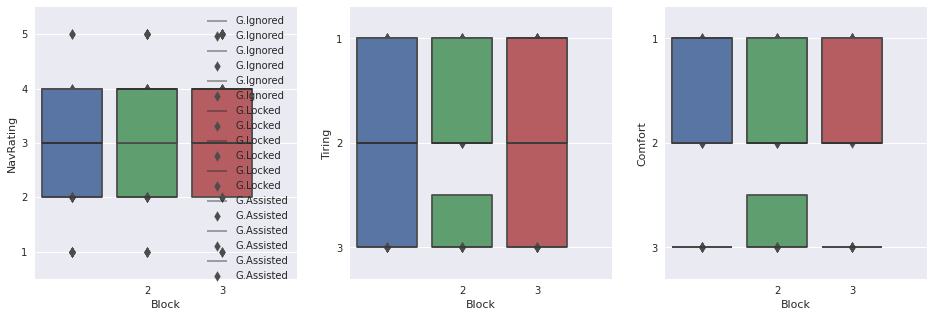

In [25]:
fig, axs = plt.subplots(1,3, figsize=(16,5), sharex=True, sharey=False)

##
plotfunc = sns.boxenplot

dat = dfByCond.loc['Gaze Ignored'].reset_index()
plotfunc(data=dat, x='Block', y='NavRating', ax=axs[0], label='G.Ignored')
plotfunc(data=dat, x='Block', y='Tiring', ax=axs[1])
plotfunc(data=dat, x='Block', y='Comfort', ax=axs[2])

dat = dfByCond.loc['Gaze Locked'].reset_index()
plotfunc(data=dat, x='Block', y='NavRating', ax=axs[0], label='G.Locked')
plotfunc(data=dat, x='Block', y='Tiring', ax=axs[1])
plotfunc(data=dat, x='Block', y='Comfort', ax=axs[2])

dat = dfByCond.loc['Gaze Asissted'].reset_index()
plotfunc(data=dat, x='Block', y='NavRating', ax=axs[0], label='G.Assisted')
plotfunc(data=dat, x='Block', y='Tiring', ax=axs[1])
plotfunc(data=dat, x='Block', y='Comfort', ax=axs[2])

axs[0].legend()

axs[0].set_ylim((.5,5.5))
axs[0].set_yticks([1,2,3,4,5])
axs[0].set_xticks([1,2,3])

axs[1].set_ylim((3.3,.7))
axs[1].set_yticks([1,2,3])

axs[2].set_ylim((3.3,.7))
axs[2].set_yticks([1,2,3])

plt.show()